In [27]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time

env = gym.make('CartPole-v1')

upperBounds = env.observation_space.high
lowerBounds = env.observation_space.low
cartVelocityMin = -3
cartVelocityMax = 3
poleAngleVelocityMin = -10
poleAngleVelocityMax = 10
upperBounds[1] = cartVelocityMax
upperBounds[3] = poleAngleVelocityMax
lowerBounds[1] = cartVelocityMin
lowerBounds[3] = poleAngleVelocityMin

numberOfBinsPosition = 30
numberOfBinsVelocity = 30
numberOfBinsAngle = 30
numberOfBinsAngleVelocity = 30
numberOfBins = [numberOfBinsPosition, numberOfBinsVelocity, numberOfBinsAngle, numberOfBinsAngleVelocity]

cartPositionBin = np.linspace(lowerBounds[0], upperBounds[0], numberOfBins[0])
cartVelocityBin = np.linspace(lowerBounds[1], upperBounds[1], numberOfBins[1])
poleAngleBin = np.linspace(lowerBounds[2], upperBounds[2], numberOfBins[2])
poleAngularVelocityBin = np.linspace(lowerBounds[3], upperBounds[3], numberOfBins[3])


numberEpisodes = 30000
alpha = 0.1
gamma = 1
epsilon = 0.2


In [28]:
def returnIndexState(state):
    position = state[0]
    velocity = state[1]
    angle = state[2]
    angularVelocity = state[3]
    
    indexPosition = np.maximum(np.digitize(position, cartPositionBin) - 1, 0) 
    indexVelocity = np.maximum(np.digitize(velocity, cartVelocityBin) - 1, 0)
    indexAngle = np.maximum(np.digitize(angle, poleAngleBin) - 1, 0)
    indexAngularVelocity = np.maximum(np.digitize(angularVelocity, poleAngularVelocityBin) - 1, 0)

    return (indexPosition, indexVelocity, indexAngle, indexAngularVelocity)


class Q_Learning:
    def __init__(self, env, alpha, gamma, epsilon, numberEpisodes):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma 
        self.epsilon = epsilon 
        self.actionNumber = env.action_space.n 
        self.numberEpisodes = numberEpisodes

        self.sumRewardsEpisode = [] 

        self.Qmatrix = np.random.uniform(low=0, high=0, size=(*numberOfBins, self.actionNumber))

    def selectAction(self, state, index):
        if index < 500:
            return np.random.choice(self.actionNumber)

        if index > 7000:
            self.epsilon = 0.999 * self.epsilon

        randomNumber = np.random.random()
        if randomNumber < self.epsilon:
            return np.random.choice(self.actionNumber)
        else:
            stateIndex = returnIndexState(state)
            return np.argmax(self.Qmatrix[stateIndex])

    def simulateEpisodes(self):
        for index in range(self.numberEpisodes):
            rewardsEpisode = []
            currState = self.env.reset()[0]
            timeStamp = 0
            terminate = False

            while not terminate and timeStamp < 1000: 
                stateIndex = returnIndexState(currState)
                action = self.selectAction(currState, index)
                stateNxt, rewards, terminate, _, _ = env.step(action)
                stateNxtIndex = returnIndexState(stateNxt)
                rewardsEpisode.append(rewards)

                if not terminate:
                    error = (rewards + self.gamma * np.max(self.Qmatrix[stateNxtIndex])) - self.Qmatrix[stateIndex + (action,)]
                    self.Qmatrix[stateIndex + (action,)] += self.alpha * error
                else:
                    error = rewards - self.Qmatrix[stateIndex + (action,)]
                    self.Qmatrix[stateIndex + (action,)] += self.alpha * error

                timeStamp += 1
                currState = stateNxt

            print(f"Episode: {index}, Rewards {np.sum(rewardsEpisode)}")        
            self.sumRewardsEpisode.append(np.sum(rewardsEpisode))

    def plotRewards(self,avg_intv):
        rwds = np.asarray(self.sumRewardsEpisode)
        score = np.sum((rwds >= 200))
        hg_score = np.sum(rwds >= 300)
        print(f"Ep Solved: {score}, High Score: {hg_score}")

        avg_rwds = np.mean(rwds.reshape(-1, avg_intv), axis=-1, keepdims=True).repeat(avg_intv, axis=1).reshape(-1)
        rwds_df = pd.DataFrame({'Rewards': rwds, 'Average_Rewards': avg_rwds})

        plt.plot(rwds_df['Rewards'], color='red', linewidth=2, label='Rewards')
        plt.plot(rwds_df['Average_Rewards'], color='orange', linestyle='dashed', linewidth=2, label='Avg Rewards')
        plt.legend()
        plt.xlabel('Episode')
        plt.ylabel('Reward')

        plt.show()

Episode: 0, Rewards 28.0
Episode: 1, Rewards 29.0
Episode: 2, Rewards 46.0
Episode: 3, Rewards 20.0
Episode: 4, Rewards 33.0
Episode: 5, Rewards 26.0
Episode: 6, Rewards 16.0
Episode: 7, Rewards 14.0
Episode: 8, Rewards 12.0
Episode: 9, Rewards 14.0
Episode: 10, Rewards 49.0
Episode: 11, Rewards 14.0
Episode: 12, Rewards 50.0
Episode: 13, Rewards 31.0
Episode: 14, Rewards 20.0
Episode: 15, Rewards 19.0
Episode: 16, Rewards 27.0
Episode: 17, Rewards 9.0
Episode: 18, Rewards 17.0
Episode: 19, Rewards 15.0
Episode: 20, Rewards 22.0
Episode: 21, Rewards 63.0
Episode: 22, Rewards 13.0
Episode: 23, Rewards 13.0
Episode: 24, Rewards 25.0
Episode: 25, Rewards 22.0
Episode: 26, Rewards 9.0
Episode: 27, Rewards 15.0
Episode: 28, Rewards 40.0
Episode: 29, Rewards 17.0
Episode: 30, Rewards 22.0
Episode: 31, Rewards 17.0
Episode: 32, Rewards 20.0
Episode: 33, Rewards 29.0
Episode: 34, Rewards 34.0
Episode: 35, Rewards 60.0
Episode: 36, Rewards 30.0
Episode: 37, Rewards 18.0
Episode: 38, Rewards 14.

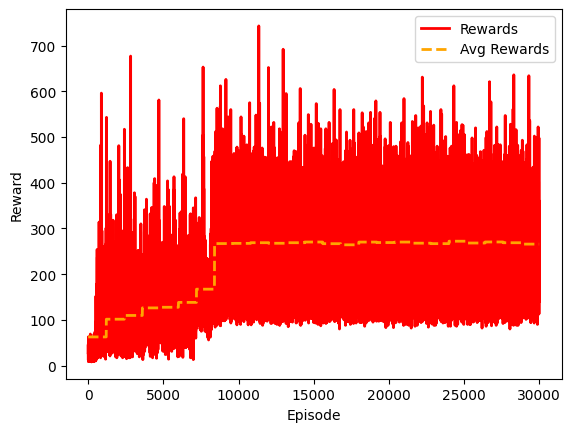

In [29]:
Q1 = Q_Learning(env, alpha, gamma, epsilon, numberEpisodes)
start = time.time()
Q1.simulateEpisodes()
end = time.time()
print(f'Time: {end - start}')

models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

Q1.plotRewards(avg_intv=1200)
np.save(os.path.join(models_dir, f'Qmatrix'), Q1.Qmatrix)

In [32]:
def play_game(env, Qmatrix):
    state = env.reset()[0]
    total_reward = 0
    terminate = False

    while not terminate:
        env.render()
        stateIndex = returnIndexState(state)
        action = np.argmax(Qmatrix[stateIndex])
        state, reward, terminate, _, _ = env.step(action)
        total_reward += reward
        time.sleep(0.02)  

    env.close()
    print(f"Total Reward: {total_reward}")

env = gym.make('CartPole-v1',render_mode="human")

Qmatrix_path = f'models/Qmatrix.npy'

try:
    Qmatrix = np.load(Qmatrix_path)
    print("Q-matrix loaded successfully!")
except FileNotFoundError:
    print(f"Error: Q-matrix file not found at {Qmatrix_path}. Train the model first.")
    exit()

play_game(env, Qmatrix)

Q-matrix loaded successfully!
Total Reward: 341.0
